<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%5BGD12%5DResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet Ablation Study

## 1. 데이터 셋 준비하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    name='cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete2CJ3T9/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


##  데이터 전처리 (Normalization)

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

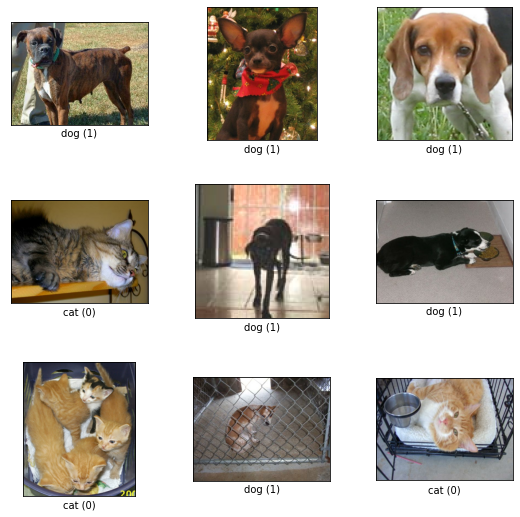

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

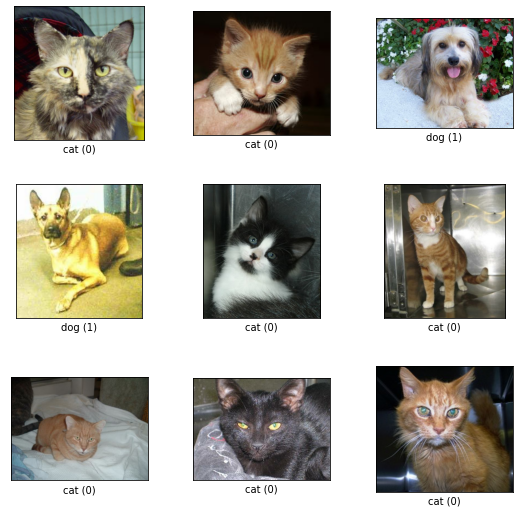

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## 기본 블록 만들기

In [17]:
# function for building VGG Block

def build_block(input_layer, num_cnn=3, channel=64, block_num=1, is_50=False):
    # 입력 레이어
    x = input_layer
    # CNN 레이어
    if is_50 :
        for 
    for cnn_num in range(num_cnn):
    
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3, 3), strides=(2, 2), name=f'stage{block_num}_conv{cnn_num}')(x)
        x = keras.layers.BatchNormalization( name=f'stage{block_num}_bn{cnn_num}')(x)
        x = keras.layers.Activation("relu", name=f'stage{block_num}_active{cnn_num}')(x)    


    return x

In [18]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_block(vgg_input_layer)    # VGG 블록 생성

In [19]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_conv0 (Conv2D)        (None, 15, 15, 64)        1792      
_________________________________________________________________
stage1_bn0 (BatchNormalizati (None, 15, 15, 64)        256       
_________________________________________________________________
stage1_active0 (Activation)  (None, 15, 15, 64)        0         
_________________________________________________________________
stage1_conv1 (Conv2D)        (None, 7, 7, 64)          36928     
_________________________________________________________________
stage1_bn1 (BatchNormalizati (None, 7, 7, 64)          256       
_________________________________________________________________
stage1_active1 (Activation)  (None, 7, 7, 64)          0   

In [20]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=2):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    output = keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same")(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation("relu")(output)
    output = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2)(output)
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
    
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [21]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_resnet()

vgg_16.summary()

ValueError: ignored